In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import time
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv("../../dataset/creditcard.csv", dtype=float)
print(df)


            Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62    0.0
1            0.0   1.191857   0.266151  ...  0.014724    2.69    0.0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66    0.0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50    0.0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99    0.0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77    0.0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79    0.0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88    0.0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00    0.0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00    0.0

[284807 rows x 31 columns]


In [3]:
X = df.drop(columns=["Time", "Class"])
y = df["Class"]
X = X[y.notna()]
y = y[y.notna()]

print(X)

               V1         V2        V3  ...       V27       V28  Amount
0       -1.359807  -0.072781  2.536347  ...  0.133558 -0.021053  149.62
1        1.191857   0.266151  0.166480  ... -0.008983  0.014724    2.69
2       -1.358354  -1.340163  1.773209  ... -0.055353 -0.059752  378.66
3       -0.966272  -0.185226  1.792993  ...  0.062723  0.061458  123.50
4       -1.158233   0.877737  1.548718  ...  0.219422  0.215153   69.99
...           ...        ...       ...  ...       ...       ...     ...
284802 -11.881118  10.071785 -9.834783  ...  0.943651  0.823731    0.77
284803  -0.732789  -0.055080  2.035030  ...  0.068472 -0.053527   24.79
284804   1.919565  -0.301254 -3.249640  ...  0.004455 -0.026561   67.88
284805  -0.240440   0.530483  0.702510  ...  0.108821  0.104533   10.00
284806  -0.533413  -0.189733  0.703337  ... -0.002415  0.013649  217.00

[284807 rows x 29 columns]


In [4]:
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X["Amount"].values.reshape(-1, 1))

print(X['Amount'])

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
            ...   
284802   -0.350151
284803   -0.254117
284804   -0.081839
284805   -0.313249
284806    0.514355
Name: Amount, Length: 284807, dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

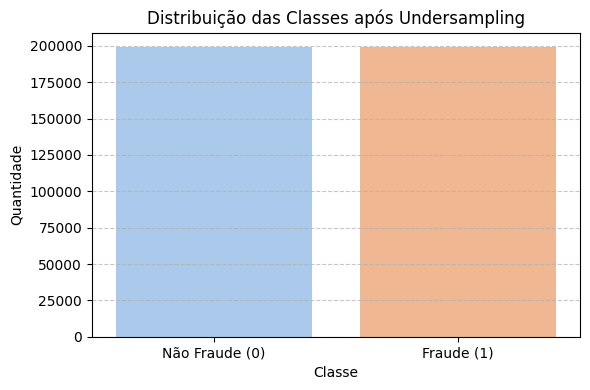

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

class_counts = y_train_resampled.value_counts().reset_index()
class_counts.columns = ['Classe', 'Quantidade']

plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts, x='Classe', y='Quantidade', hue='Classe', palette='pastel', legend=False)

plt.title("Distribuição das Classes após Undersampling")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não Fraude (0)", "Fraude (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}
scoring = 'recall'

start_time = time.time()
grid_search = GridSearchCV(estimator=base_model,
    param_grid=param_grid,
    cv=5, 
    scoring=scoring,
    n_jobs=-1,  
    verbose=2,
    return_train_score=True)
grid_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

print(f"Tempo de execução do GridSearchCV: {end_time - start_time:.2f} segundos")
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

print(f"\nMelhor pontuação de {scoring}: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')

print("\nTop 5 combinações de parâmetros:")
cols = ['params', 'mean_test_score', 'rank_test_score', 'mean_train_score']
print(results[cols].head(5))

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:58] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:04] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:10] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   9.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   9.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:20] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:25] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.9s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.9s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300; total time=  12.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300; total time=  12.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300; total time=  13.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   8.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300; total time=  13.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:39] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  11.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   8.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  12.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  12.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  13.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.7s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:16:58] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=  18.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=  18.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=  12.8s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=  12.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.7s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   7.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   7.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   7.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   7.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   8.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=  16.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=  16.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=  16.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=  16.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=  16.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:17] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  13.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  13.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  13.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=  16.7s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.8s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=  16.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=  16.8s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=  17.3s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=  11.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=  20.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=  12.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200; total time=  15.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200; total time=  17.5s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200; total time=  17.7s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200; total time=  21.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100; total time=  12.5s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200; total time=  16.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100; total time=  11.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300; total time=  23.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300; total time=  25.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300; total time=  23.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300; total time=  24.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200; total time=  15.5s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300; total time=  28.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200; total time=  17.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200; total time=  18.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200; total time=  18.3s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200; total time=  15.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:13] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.2s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=  10.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=  10.3s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300; total time=  22.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300; total time=  23.1s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300; total time=  22.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300; total time=  22.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300; total time=  23.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200; total time=  15.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200; total time=  15.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200; total time=  16.9s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.4s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200; total time=  14.3s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   6.0s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200; total time=  16.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.6s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300; total time=  24.1s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300; total time=  22.1s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300; total time=  21.0s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300; total time=  23.7s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300; total time=  22.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:49] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  12.5s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  10.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  12.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.9s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  10.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  10.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:56] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   7.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.2s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  10.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:18:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100; total time=   7.9s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  11.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.7s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.6s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100; total time=   6.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.6s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100; total time=   6.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=  12.5s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=  12.5s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=  14.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200; total time=  11.7s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200; total time=  12.0s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.5s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.5s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300; total time=  12.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.7s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   9.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300; total time=  12.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:23] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300; total time=  16.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=  12.0s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=  13.4s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=  12.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.8s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=  17.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=  17.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=  17.3s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=  18.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   6.9s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=  18.6s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=  17.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=  22.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=  10.3s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100; total time=   7.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=  14.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.3s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=  14.4s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=  14.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100; total time=   9.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=  15.8s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=  17.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=  18.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=  17.7s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=  18.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100; total time=   9.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:01] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  10.7s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  17.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  17.1s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=  10.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=  12.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300; total time=  16.3s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   8.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   8.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300; total time=  17.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300; total time=  17.8s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300; total time=  17.9s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300; total time=  21.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:21] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200; total time=  17.1s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100; total time=  10.6s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200; total time=  18.3s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200; total time=  15.9s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100; total time=  11.7s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200; total time=  19.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:33] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200; total time=  19.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300; total time=  21.5s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300; total time=  21.5s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100; total time=   8.7s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100; total time=   8.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300; total time=  22.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:44] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300; total time=  22.9s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300; total time=  22.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200; total time=  12.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200; total time=  17.3s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200; total time=  18.2s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.4s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.2s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200; total time=  14.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=   8.2s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200; total time=  18.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:20:57] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300; total time=  18.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300; total time=  19.3s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=  11.1s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300; total time=  21.4s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=  11.3s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300; total time=  21.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:08] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300; total time=  25.7s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200; total time=  12.8s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200; total time=  14.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.2s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200; total time=  12.9s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200; total time=  14.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:13] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200; total time=  15.4s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.8s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:20] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.5s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300; total time=  17.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   7.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300; total time=  17.9s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=  10.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=  10.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300; total time=  20.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300; total time=  21.6s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300; total time=  21.4s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.7s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.7s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=  10.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:32] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   9.9s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   5.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.9s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=  11.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:37] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   7.7s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.5s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   8.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.6s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100; total time=   5.5s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=  10.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=  10.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:43] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100; total time=   4.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100; total time=   4.7s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100; total time=   4.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=  13.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=  13.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200; total time=   7.8s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200; total time=   8.9s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200; total time=   7.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:54] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.6s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300; total time=  10.9s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   7.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.8s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.8s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300; total time=  11.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   6.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:21:59] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  10.9s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  13.3s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   9.0s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  11.5s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  11.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  13.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   6.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   7.4s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=  15.5s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=  16.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=  18.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:20] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=  10.4s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=  10.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=  11.9s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=  10.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.8s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:27] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.8s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100; total time=   6.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=  15.3s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=  14.8s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=  15.7s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=  15.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=  15.5s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:7

[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200; total time=  10.4s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200; total time=  10.6s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.5s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200; total time=  11.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200; total time=  10.2s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100; total time=   8.9s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.1s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100; total time=   8.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300; total time=  15.0s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.1s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100; total time=   9.4s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300; total time=  16.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300; total time=  15.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300; total time=  14.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300; total time=  15.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200; total time=  15.2s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200; total time=  13.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100; total time=   8.4s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200; total time=  14.7s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200; total time=  14.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200; total time=  14.0s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100; total time=   7.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100; total time=   9.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100; total time=   7.7s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300; total time=  18.9s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300; total time=  20.3s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300; total time=  21.5s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300; total time=  21.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300; total time=  20.4s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200; total time=  13.4s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200; total time=  13.3s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200; total time=  12.7s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200; total time=  14.3s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200; total time=  12.8s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100; total time=   7.8s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100; total time=   9.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100; total time=   8.3s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100; total time=   8.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100; total time=   8.1s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300; total time=  17.5s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300; total time=  17.6s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300; total time=  17.4s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300; total time=  20.3s


/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200; total time=  12.0s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200; total time=  13.2s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300; total time=  22.6s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200; total time=  16.9s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200; total time=  12.6s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200; total time=  15.5s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300; total time=  15.4s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300; total time=  15.2s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300; total time=  14.2s
[CV] END learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300; total time=  14.4s
[CV] END learning_ra

/home/mias/Documentos/UFPI/TCC/CC-Fraud-Detector/Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tempo de execução do GridSearchCV: 474.21 segundos

Melhores parâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}

Melhor pontuação de recall: 1.0000

Top 5 combinações de parâmetros:
                                               params  ...  mean_train_score
38  {'learning_rate': 0.1, 'max_depth': 5, 'min_ch...  ...               1.0
79  {'learning_rate': 0.2, 'max_depth': 7, 'min_ch...  ...               1.0
70  {'learning_rate': 0.2, 'max_depth': 5, 'min_ch...  ...               1.0
71  {'learning_rate': 0.2, 'max_depth': 5, 'min_ch...  ...               1.0
68  {'learning_rate': 0.2, 'max_depth': 5, 'min_ch...  ...               1.0

[5 rows x 4 columns]


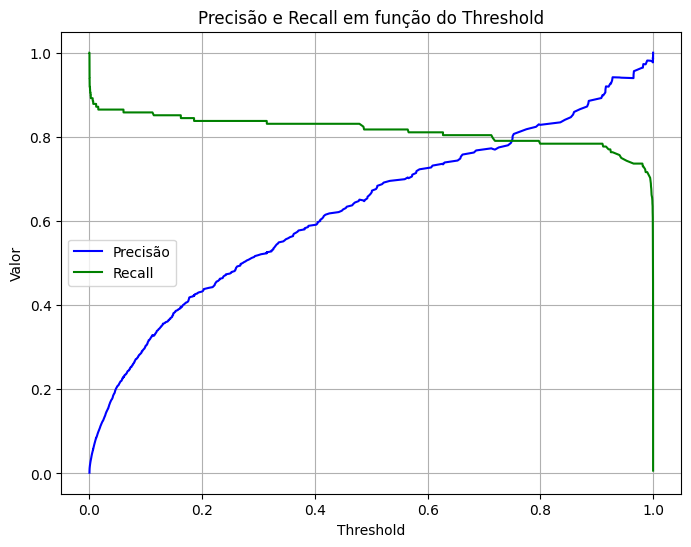

In [8]:
y_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precisão", color="b")
plt.plot(thresholds, recall[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Precisão e Recall em função do Threshold")
plt.legend()
plt.grid()
plt.show()

Relatório de Classificação (com threshold ajustado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.65      0.83      0.73       148

    accuracy                           1.00     85443
   macro avg       0.82      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.9699


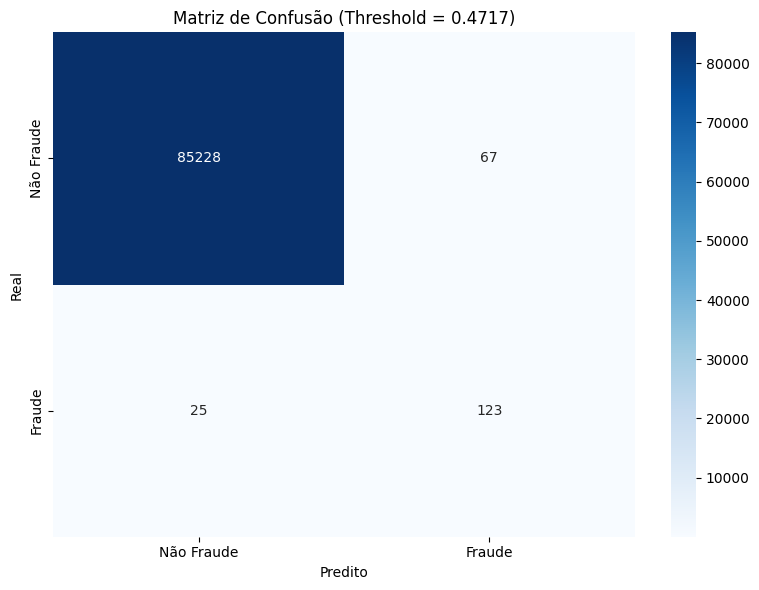

In [13]:
THRESHOLD = 0.4717
y_pred_adjusted = (y_proba >= THRESHOLD).astype(int)

print("Relatório de Classificação (com threshold ajustado):")
print(classification_report(y_test, y_pred_adjusted))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Não Fraude", "Fraude"],
            yticklabels=["Não Fraude", "Fraude"])
plt.title(f"Matriz de Confusão (Threshold = {THRESHOLD})")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


Comparação de diferentes thresholds:
Threshold: 0.1000, Accuracy: 0.9964, Precision: 0.3046, Recall: 0.8581, F1: 0.4496
Threshold: 0.2000, Accuracy: 0.9978, Precision: 0.4336, Recall: 0.8378, F1: 0.5714
Threshold: 0.3000, Accuracy: 0.9984, Precision: 0.5210, Recall: 0.8378, F1: 0.6425
Threshold: 0.4000, Accuracy: 0.9987, Precision: 0.5913, Recall: 0.8311, F1: 0.6910
Threshold: 0.5000, Accuracy: 0.9990, Precision: 0.6685, Recall: 0.8176, F1: 0.7356
Threshold: 0.0057, Accuracy: 0.9726, Precision: 0.0537, Recall: 0.8919, F1: 0.1012
Threshold: 0.9281, Accuracy: 0.9995, Precision: 0.9417, Recall: 0.7635, F1: 0.8433
Threshold: 0.4717, Accuracy: 0.9989, Precision: 0.6474, Recall: 0.8311, F1: 0.7278


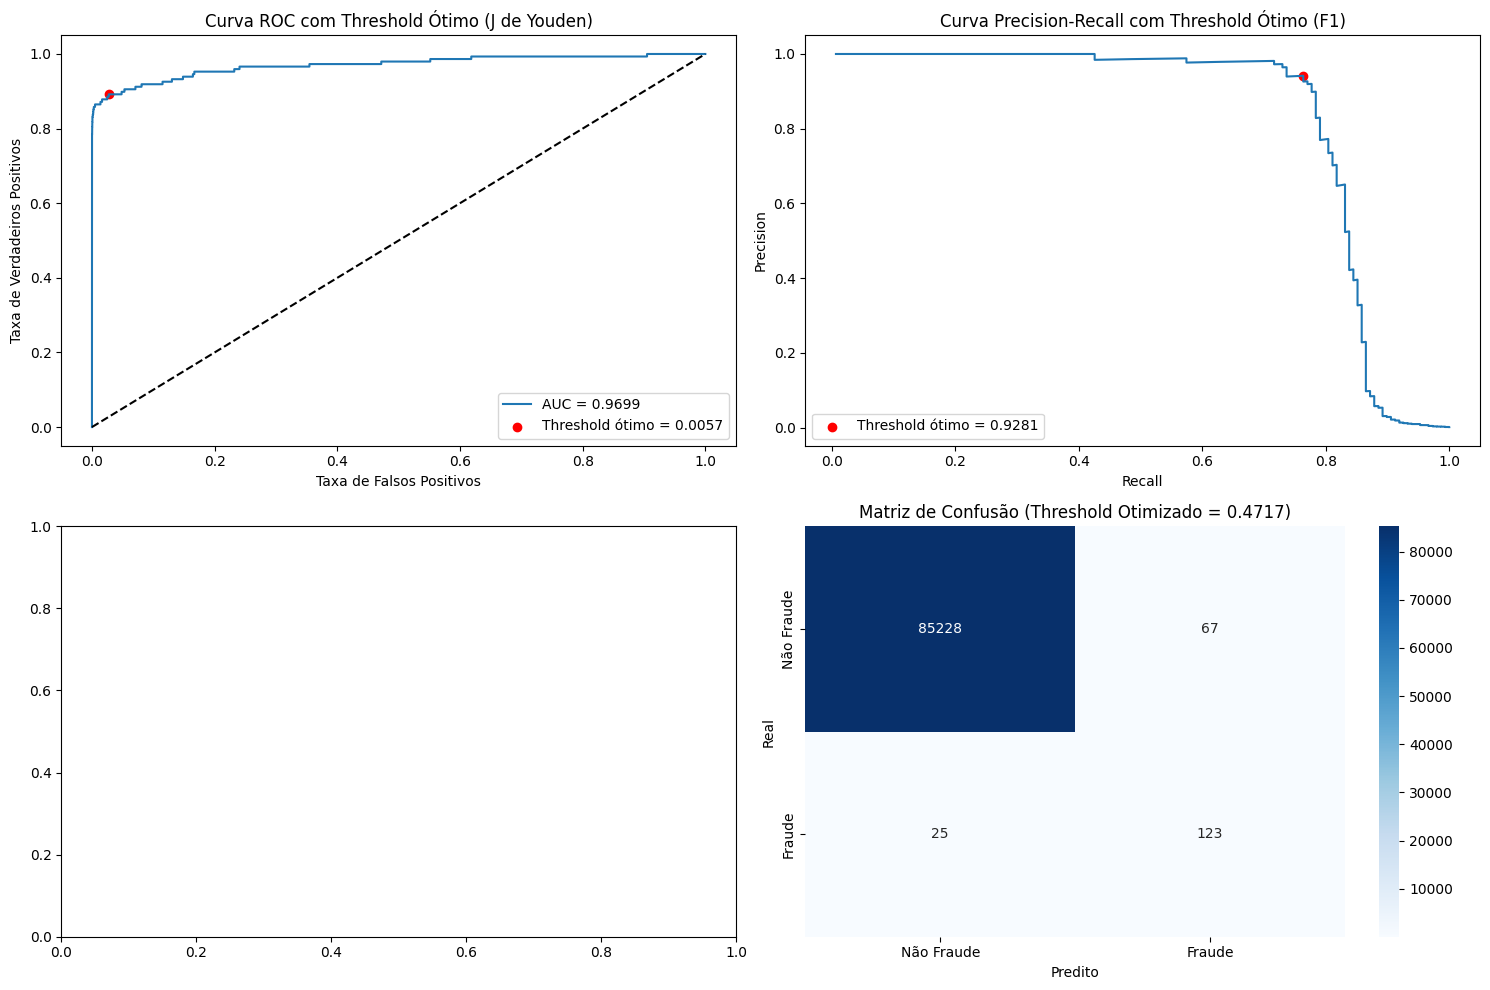


Threshold ótimo baseado na Curva ROC (J de Youden): 0.0057
Threshold ótimo baseado em F1-Score: 0.9281
Threshold ótimo baseado na análise de custo: 0.4717

Relatório de Classificação (com threshold recomendado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.65      0.83      0.73       148

    accuracy                           1.00     85443
   macro avg       0.82      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, classification_report, confusion_matrix, roc_auc_score

# 1. Usando a curva ROC e o ponto J de Youden
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
# Índice do threshold que maximiza TPR - FPR (ponto J de Youden)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_roc = thresholds_roc[optimal_idx]

# 2. Usando a curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
# Para calcular F1-score para cada threshold
f1_scores = []
for threshold in thresholds_pr:
    y_pred_temp = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)
    
optimal_idx_pr = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]

# 3. Análise customizada (exemplo com custo)
# Definir custos: por exemplo, falso negativo (fraude não detectada) é 10x mais custoso que falso positivo
cost_of_fp = 1  # Custo de um falso positivo
cost_of_fn = 10  # Custo de um falso negativo

best_threshold = None
lowest_cost = float('inf')
threshold_range = np.linspace(0.1, 0.9, 100)

for threshold in threshold_range:
    y_pred_temp = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    
    fp = cm[0, 1]  # Falsos positivos
    fn = cm[1, 0]  # Falsos negativos
    
    total_cost = (fp * cost_of_fp) + (fn * cost_of_fn)
    
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold

# Visualizações
plt.figure(figsize=(15, 10))

# Curva ROC com threshold ótimo
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
            label=f'Threshold ótimo = {optimal_threshold_roc:.4f}')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC com Threshold Ótimo (J de Youden)')
plt.legend()

# Curva Precision-Recall com threshold ótimo
plt.subplot(2, 2, 2)
plt.plot(recall[:-1], precision[:-1])
precision_at_optimal = precision[np.where(thresholds_pr == optimal_threshold_pr)[0][0]]
recall_at_optimal = recall[np.where(thresholds_pr == optimal_threshold_pr)[0][0]]
plt.scatter(recall_at_optimal, precision_at_optimal, marker='o', color='red',
            label=f'Threshold ótimo = {optimal_threshold_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall com Threshold Ótimo (F1)')
plt.legend()

# Comparação de métricas por threshold
plt.subplot(2, 2, 3)
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold_roc, optimal_threshold_pr, best_threshold]
metrics = []

for thresh in thresholds_to_test:
    y_pred_temp = (y_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics.append({
        'threshold': thresh,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Exibir resultados dos thresholds
print("\nComparação de diferentes thresholds:")
for m in metrics:
    print(f"Threshold: {m['threshold']:.4f}, Accuracy: {m['accuracy']:.4f}, "
          f"Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}, F1: {m['f1']:.4f}")

# Matriz de confusão para o melhor threshold baseado em custo
plt.subplot(2, 2, 4)
y_pred_best = (y_proba >= best_threshold).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Fraude", "Fraude"],
            yticklabels=["Não Fraude", "Fraude"])
plt.title(f"Matriz de Confusão (Threshold Otimizado = {best_threshold:.4f})")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.tight_layout()
plt.show()

print(f"\nThreshold ótimo baseado na Curva ROC (J de Youden): {optimal_threshold_roc:.4f}")
print(f"Threshold ótimo baseado em F1-Score: {optimal_threshold_pr:.4f}")
print(f"Threshold ótimo baseado na análise de custo: {best_threshold:.4f}")

# Relatório para o threshold recomendado final (escolha um dos métodos)
recommended_threshold = best_threshold  # Ou optimal_threshold_roc ou optimal_threshold_pr
y_pred_recommended = (y_proba >= recommended_threshold).astype(int)

print("\nRelatório de Classificação (com threshold recomendado):")
print(classification_report(y_test, y_pred_recommended))